In [1]:
# Import necessary libraries
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive to access datasets
from google.colab import drive

# Import libraries from the Hugging Face Transformers library
import transformers
from transformers import BertTokenizer  # For tokenizing the text data
from torch.utils.data import TensorDataset, random_split  # For handling datasets
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler  # For data loading
from transformers import BertForSequenceClassification, AdamW, BertConfig  # For BERT model and configuration
from transformers import get_linear_schedule_with_warmup  # For learning rate scheduling

# Import metrics for model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
import tensorflow as tf

In [ ]:
# Check for available GPU and set the device for PyTorch
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla T4


# **TON_IOT**

In [ ]:
# Load the TON IoT dataset from a CSV file and retrieve its shape
# Ensure the CSV file is located at the specified path
df_TON_IOT = pd.read_csv('/content/drive/MyDrive/train_test_network (1).csv')
shape = df_TON_IOT.shape


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

df_TON_IOT.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [ ]:
df_TON_IOT.head()
print('Dataframe shape: ', shape)
print('Number of rows: ', shape[0])
print('Number of columns: ', shape[1])
#df.shape

Dataframe shape:  (211043, 44)
Number of rows:  211043
Number of columns:  44


In [ ]:

df_TON_IOT.isnull().sum()

,0
src_ip,0
src_port,0
dst_ip,0
dst_port,0
proto,0
service,0
duration,0
src_bytes,0
dst_bytes,0
conn_state,0


In [ ]:
df_TON_IOT[df_TON_IOT.duplicated()].shape

(20569, 44)

In [ ]:

# Display the duplicate rows
duplicate_rows = df_TON_IOT[df_TON_IOT.duplicated()]
print(duplicate_rows)


               src_ip  src_port          dst_ip  dst_port proto service  \
21      192.168.1.193     49180    192.168.1.37      8080   tcp       -   
151     192.168.1.193     49194    192.168.1.33      8080   tcp       -   
322     192.168.1.193     49234    192.168.1.37      8080   tcp       -   
330     192.168.1.193     49234    192.168.1.37      8080   tcp       -   
348     192.168.1.193     49236    192.168.1.37      8080   tcp       -   
...               ...       ...             ...       ...   ...     ...   
211032   192.168.1.32     47514  18.194.169.124        80   tcp       -   
211033   192.168.1.32     47518  18.194.169.124        80   tcp       -   
211034   192.168.1.32     47634  18.194.169.124        80   tcp       -   
211035   192.168.1.32     48134  18.194.169.124        80   tcp       -   
211036   192.168.1.32     48156  18.194.169.124        80   tcp       -   

        duration  src_bytes  dst_bytes conn_state  ...  \
21      0.000127          0          0   

In [ ]:
# Remove duplicate rows and keep the first occurrence
df_TON_IOT_cleaned = df_TON_IOT.drop_duplicates()


In [ ]:
df_TON_IOT_cleaned[df_TON_IOT_cleaned.duplicated()].shape

(0, 44)

In [ ]:
df_TON_IOT.shape

(211043, 44)

In [ ]:


df_TON_IOT_cleaned.shape

(190474, 44)

In [ ]:
df_TON_IOT_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190474 entries, 0 to 211042
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  190474 non-null  object 
 1   src_port                190474 non-null  int64  
 2   dst_ip                  190474 non-null  object 
 3   dst_port                190474 non-null  int64  
 4   proto                   190474 non-null  object 
 5   service                 190474 non-null  object 
 6   duration                190474 non-null  float64
 7   src_bytes               190474 non-null  int64  
 8   dst_bytes               190474 non-null  int64  
 9   conn_state              190474 non-null  object 
 10  missed_bytes            190474 non-null  int64  
 11  src_pkts                190474 non-null  int64  
 12  src_ip_bytes            190474 non-null  int64  
 13  dst_pkts                190474 non-null  int64  
 14  dst_ip_bytes            1

In [ ]:

df_TON_IOT_cleaned.shape

(190474, 44)

In [ ]:
# Drop the 'label' column from the DataFrame
df_TON_IOT_cleaned = df_TON_IOT_cleaned.drop('label', axis = 1)

In [ ]:

from sklearn.preprocessing import LabelEncoder
# Specify the columns to be encoded
columns_to_encode = ['src_ip', 'dst_ip', 'proto', 'service','conn_state','dns_query', 'dns_AA', 'dns_RD','dns_RA','dns_rejected','ssl_version','ssl_cipher','ssl_resumed','ssl_established','ssl_subject','ssl_issuer', 'http_trans_depth', 'http_method','http_uri','http_version','http_user_agent','http_orig_mime_types','http_resp_mime_types','weird_name','weird_addl','weird_notice']
for column in columns_to_encode:
    le = LabelEncoder()
    df_TON_IOT_cleaned[column] = le.fit_transform(df_TON_IOT_cleaned[column])
df_TON_IOT_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190474 entries, 0 to 211042
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  190474 non-null  int64  
 1   src_port                190474 non-null  int64  
 2   dst_ip                  190474 non-null  int64  
 3   dst_port                190474 non-null  int64  
 4   proto                   190474 non-null  int64  
 5   service                 190474 non-null  int64  
 6   duration                190474 non-null  float64
 7   src_bytes               190474 non-null  int64  
 8   dst_bytes               190474 non-null  int64  
 9   conn_state              190474 non-null  int64  
 10  missed_bytes            190474 non-null  int64  
 11  src_pkts                190474 non-null  int64  
 12  src_ip_bytes            190474 non-null  int64  
 13  dst_pkts                190474 non-null  int64  
 14  dst_ip_bytes            1

In [ ]:
df_TON_IOT_cleaned.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,type
0,26,4444,201,49178,1,0,290.371539,101568,2592,0,...,0,0,0,0,0,0,0,0,0,backdoor
1,16,49180,210,8080,1,0,0.000102,0,0,1,...,0,0,0,0,0,0,0,0,0,backdoor
2,16,49180,210,8080,1,0,0.000148,0,0,1,...,0,0,0,0,0,0,0,0,0,backdoor
3,16,49180,210,8080,1,0,0.000113,0,0,1,...,0,0,0,0,0,0,0,0,0,backdoor
4,16,49180,210,8080,1,0,0.000130,0,0,1,...,0,0,0,0,0,0,0,0,0,backdoor


In [ ]:
# Display the count of each unique value in the 'type' column
print(df_TON_IOT_cleaned.groupby("type").size())

type
backdoor      18711
ddos          19993
dos           18992
injection     19964
mitm           1041
normal        42040
password      19861
ransomware    14735
scanning      20000
xss           15137
dtype: int64


In [ ]:
# Separate the features X_TON_IOT from the target variable y_TON_IOT
X_TON_IOT = df_TON_IOT_cleaned.drop('type', axis = 1)
y_TON_IOT = df_TON_IOT_cleaned['type']
X_TON_IOT.shape, y_TON_IOT.shape

((190474, 42), (190474,))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
X_TON_IOT_train, X_TON_IOT_test,y_TON_IOT_train, y_TON_IOT_test = train_test_split(X_TON_IOT, y_TON_IOT, test_size=0.4, random_state = 1337
)
# Further split the test set into validation and test sets
# 50% of the original test set will be used for validation and 50% for the final test
X_TON_IOT_valid, X_TON_IOT_test2,y_TON_IOT_valid, y_TON_IOT_test2 = train_test_split(X_TON_IOT_test, y_TON_IOT_test, test_size=0.5, random_state = 1337
)

In [ ]:
from imblearn.combine import SMOTETomek

# Create the SMOTE-TOMEK
smt = SMOTETomek(random_state=42)

# Apply SMOTE-TOMEK to balance the classes
X_TON_IOT_train, y_TON_IOT_train = smt.fit_resample(X_TON_IOT_train, y_TON_IOT_train)


In [ ]:
from imblearn.combine import SMOTETomek
# Apply SMOTE-TOMEK to balance the classes
X_TON_IOT_valid, y_TON_IOT_valid = smt.fit_resample(X_TON_IOT_valid, y_TON_IOT_valid)


In [ ]:
# Concatenate the training features and labels to form the training DataFrame
train_df = pd.concat([X_TON_IOT_train, y_TON_IOT_train], axis=1)
# Concatenate the validation features and labels to form the validation DataFrame
val_df = pd.concat([X_TON_IOT_valid, y_TON_IOT_valid], axis=1)
# Concatenate the test features and labels to form the test DataFrame
test_df = pd.concat([X_TON_IOT_test2,y_TON_IOT_test2 ], axis=1)

In [ ]:
df= df_TON_IOT_cleaned

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import time
import datetime
import random

# Select columns to concatenate into a single "text" column for training set
columns_to_concat = [col for col in train_df.columns if col not in [ 'type']]
train_df['text'] = train_df[columns_to_concat].astype(str).agg(' '.join, axis=1)
# Keep only the "type" and "text" columns
train_df = train_df[[ 'type', 'text']]
# Shuffle the training data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Repeat the process for the validation set
columns_to_concat = [col for col in val_df.columns if col not in [ 'type']]
val_df['text'] = val_df[columns_to_concat].astype(str).agg(' '.join, axis=1)
val_df = val_df[['type', 'text']]
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Repeat the process for the test set
columns_to_concat = [col for col in test_df.columns if col not in ['type']]
test_df['text'] = test_df[columns_to_concat].astype(str).agg(' '.join, axis=1)
test_df = test_df[[ 'type', 'text']]
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the processed datasets to CSV files
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

# Display the size of each dataset
print(f'Train set size: {train_df.shape[0]}')
print(f'Validation set size: {val_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')


Train set size: 250000
Validation set size: 84732
Test set size: 38095


In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
# Fit the label encoder on the training set labels and transform them
train_df['encoded_categories'] = label_encoder.fit_transform(train_df["type"])
# Use the fitted encoder to transform the labels in the validation set
val_df['encoded_categories'] = label_encoder.transform(val_df["type"])
# Use the fitted encoder to transform the labels in the test set
test_df['encoded_categories'] = label_encoder.transform(test_df["type"])

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Set the maximum sequence length for BERT input
max_len = 80
# Function to prepare the data for BERT
def prepare_data(df, max_len, tokenizer):
    texts = df.text.values
    labels = df.encoded_categories.values

    input_ids = []
    attention_masks = []
  # Tokenize and encode each text
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add special tokens ([CLS] and [SEP])
            max_length=max_len,   # Pad or truncate to the specified length
            padding='max_length',   # Pad to the maximum length
            return_attention_mask=True,  # Return the attention mask
            return_tensors='pt', # Return PyTorch tensors
            truncation=True,     # Truncate sequences longer than max_len
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
 # Convert lists of tensors to a single tensor
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
 # Return a TensorDataset
    return TensorDataset(input_ids, attention_masks, labels)
# Prepare the datasets for training, validation, and testing
train_dataset = prepare_data(train_df, max_len, tokenizer)
val_dataset = prepare_data(val_df, max_len, tokenizer)
test_dataset = prepare_data(test_df, max_len, tokenizer)

# Set the batch size
batch_size = 32
# Create DataLoader for training with random shuffling
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
# Create DataLoader for validation
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# Create DataLoader for testing
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Determine the number of unique categories in the training data
number_of_categories = len(train_df['encoded_categories'].unique())


# Initialize the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=number_of_categories,
    output_attentions=False,
    output_hidden_states=False,
)


# Move the model to the GPU if available
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Number of training epochs
epochs = 1
# Configure the optimizer for fine-tuning the BERT model
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
# Calculate the total number of training steps
total_steps = len(train_dataloader) * epochs
# Configure the learning rate scheduler to gradually decrease the learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Function to format elapsed time as a string
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Set random seeds for reproducibility
seed_val = 1903
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []  # List to store training statistics
total_t0 = time.time()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time() # Record the start time for the epoch
    total_train_loss = 0  # Initialize the total loss for the epoch
    total_train_accuracy = 0  # Initialize the total loss for the epoch
    model.train() # Set the model to training mode

    # Loop over batches in the training data
    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:  # Display progress every 10 batches
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # Move input data to GPU
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss  # Extract the loss
        logits = outputs.logits # Extract the predicted logits

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients to prevent exploding gradients
        optimizer.step()  # Update parameters and learning rate
        scheduler.step()


       # Calculate the average training loss and accuracy for the epoch
        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        total_train_accuracy += accuracy_score(b_labels.cpu().numpy(), preds)
    # Record training statistics
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.6f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))
    print("Training Accuracy: {0:.6f}".format(avg_train_accuracy))

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Training Accur.': avg_train_accuracy,
        'Training Time': training_time
    })
# Display the total training time
print("Training completed in {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


======== Epoch 1 / 1 ========
Batch    10  of  7,813.    Elapsed: 0:00:06.
Batch    20  of  7,813.    Elapsed: 0:00:09.
Batch    30  of  7,813.    Elapsed: 0:00:13.
Batch    40  of  7,813.    Elapsed: 0:00:17.
Batch    50  of  7,813.    Elapsed: 0:00:21.
Batch    60  of  7,813.    Elapsed: 0:00:25.
Batch    70  of  7,813.    Elapsed: 0:00:28.
Batch    80  of  7,813.    Elapsed: 0:00:32.
Batch    90  of  7,813.    Elapsed: 0:00:36.
Batch   100  of  7,813.    Elapsed: 0:00:40.
Batch   110  of  7,813.    Elapsed: 0:00:44.
Batch   120  of  7,813.    Elapsed: 0:00:48.
Batch   130  of  7,813.    Elapsed: 0:00:52.
Batch   140  of  7,813.    Elapsed: 0:00:56.
Batch   150  of  7,813.    Elapsed: 0:01:00.
Batch   160  of  7,813.    Elapsed: 0:01:04.
Batch   170  of  7,813.    Elapsed: 0:01:08.
Batch   180  of  7,813.    Elapsed: 0:01:12.
Batch   190  of  7,813.    Elapsed: 0:01:16.
Batch   200  of  7,813.    Elapsed: 0:01:19.
Batch   210  of  7,813.    Elapsed: 0:01:23.
Batch   220  of  7,813.  

<ipython-input-37-63f2d1a64e65>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10').colors


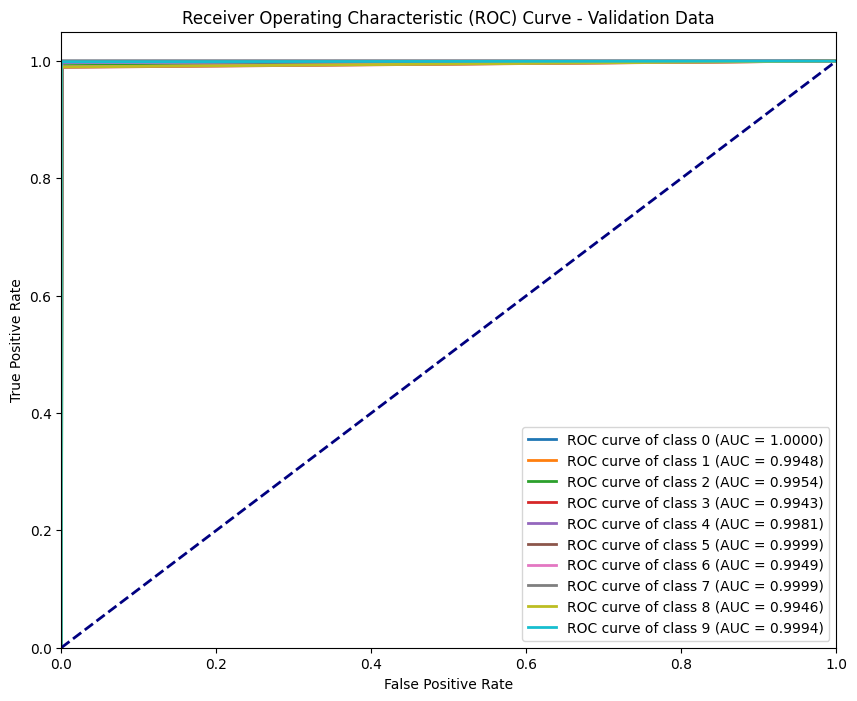

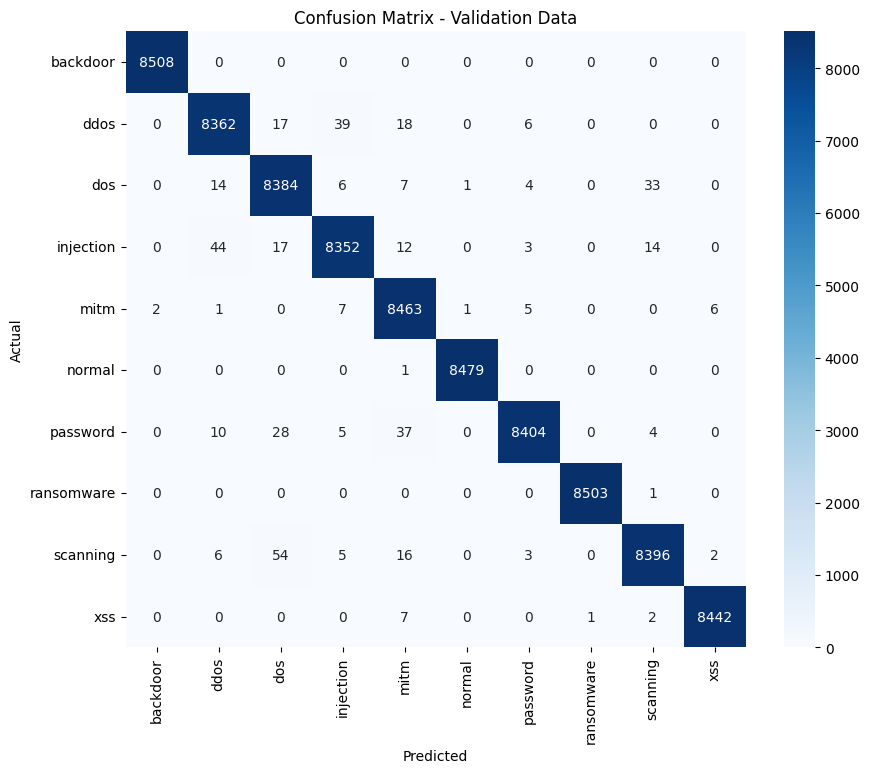

Classification Report - Validation Data:
              precision    recall  f1-score   support

    backdoor   0.999765  1.000000  0.999882      8508
        ddos   0.991111  0.990524  0.990817      8442
         dos   0.986353  0.992307  0.989321      8449
   injection   0.992631  0.989339  0.990982      8442
        mitm   0.988553  0.997407  0.992960      8485
      normal   0.999764  0.999882  0.999823      8480
    password   0.997507  0.990104  0.993792      8488
  ransomware   0.999882  0.999882  0.999882      8504
    scanning   0.993609  0.989861  0.991732      8482
         xss   0.999053  0.998817  0.998935      8452

    accuracy                       0.994819     84732
   macro avg   0.994823  0.994812  0.994813     84732
weighted avg   0.994830  0.994819  0.994820     84732



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()
total_eval_loss = 0   # Initialize total evaluation loss
predictions, true_labels = [], []   # Lists to hold predictions and true labels

# Loop through the validation DataLoader
for batch in val_dataloader:
    b_input_ids = batch[0].cuda()  # Move input IDs to GPU
    b_input_mask = batch[1].cuda()  # Move attention mask to GPU
    b_labels = batch[2].cuda()  # Move true labels to GPU

 # Disable gradient calculations for evaluation
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)  # Get model outputs
        loss = outputs.loss # Extract loss from model outputs
        logits = outputs.logits  # Extract logits from model outputs

    total_eval_loss += loss.item()

    preds = logits.argmax(dim=1)  # Get predicted class indices
    predictions.extend(preds.tolist())  # Append predictions to the list
    true_labels.extend(b_labels.tolist())   # Append true labels to the list

# Calculate average validation loss
avg_val_loss = total_eval_loss / len(val_dataloader)

# Convert predictions and true labels to numpy arrays for further processing
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compute ROC curve and ROC area for each class
n_classes = number_of_categories
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10').colors
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Data')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot the confusion matrix for validation data
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Print classification report
print("Classification Report - Validation Data:")
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_, digits=6))


In [ ]:
# Calculate accuracy
accuracy = np.mean(predictions == true_labels)

# Calculate other metrics
val_precision = precision_score(true_labels, predictions, average='weighted')
val_recall = recall_score(true_labels, predictions, average='weighted')
val_f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Validation Loss: {avg_val_loss}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')

Validation Loss: 0.021184734997154987
Validation Accuracy: 0.9948
Validation Precision: 0.9948
Validation Recall: 0.9948
Validation F1 Score: 0.9948


<ipython-input-40-5cb56d6aeaea>:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10').colors


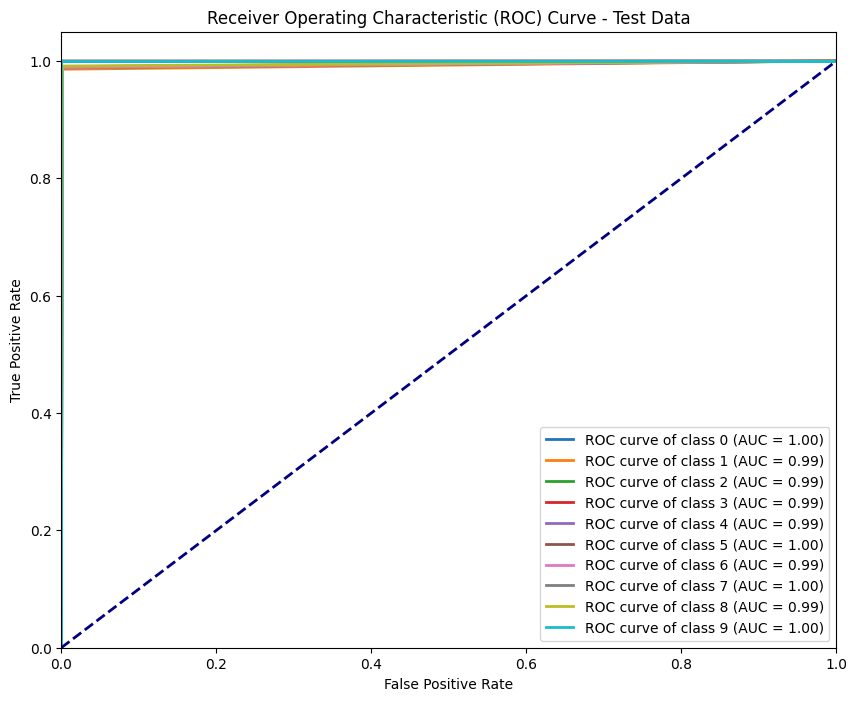

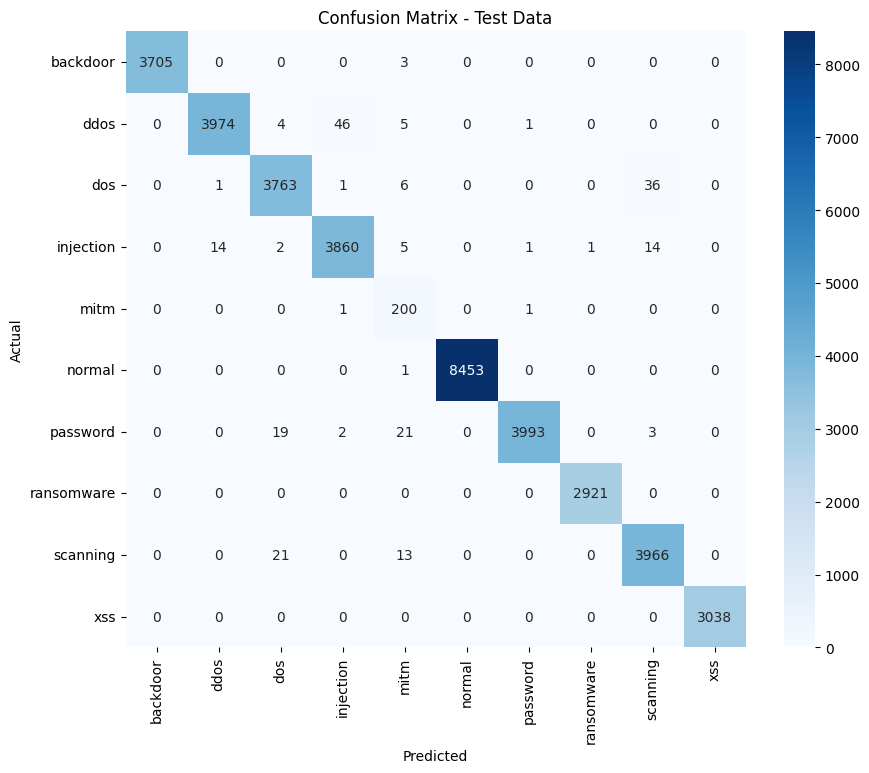

Classification Report - Test Data:
              precision    recall  f1-score   support

    backdoor   1.000000  0.999191  0.999595      3708
        ddos   0.996240  0.986104  0.991146      4030
         dos   0.987923  0.988442  0.988183      3807
   injection   0.987212  0.990506  0.988856      3897
        mitm   0.787402  0.990099  0.877193       202
      normal   1.000000  0.999882  0.999941      8454
    password   0.999249  0.988856  0.994025      4038
  ransomware   0.999658  1.000000  0.999829      2921
    scanning   0.986813  0.991500  0.989151      4000
         xss   1.000000  1.000000  1.000000      3038

    accuracy                       0.994172     38095
   macro avg   0.974450  0.993458  0.982792     38095
weighted avg   0.994469  0.994172  0.994253     38095

Prediction time: 144.41 seconds


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import time
import numpy as np

# Evaluation on test set
model.eval()
total_eval_loss = 0
predictions, true_labels = [], []

# Measure prediction time
start_time = time.time()


# Iterate over the test data loader
for batch in test_dataloader:
    b_input_ids = batch[0].cuda() # Move input IDs to GPU
    b_input_mask = batch[1].cuda() # Move attention mask to GPU
    b_labels = batch[2].cuda()  # Move true labels to GPU
    # Disable gradient tracking
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss  # Get the loss from the outputs
        logits = outputs.logits  # Get the predicted logits

    total_eval_loss += loss.item()

    preds = logits.argmax(dim=1)
    predictions.extend(preds.tolist())       # Store predictions
    true_labels.extend(b_labels.tolist())    # Store true labels

# Calculate total prediction time
prediction_time = time.time() - start_time  # End timer for prediction time

avg_test_loss = total_eval_loss / len(test_dataloader)  # Calculate average test loss

# Convert logits to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compute ROC curve and ROC area for each class
n_classes = number_of_categories
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10').colors
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot the confusion matrix for test data
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Test Data')
plt.show()

# Print classification report
print("Classification Report - Test Data:")
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_, digits=6))

# Print prediction time
print("Prediction time: {:.2f} seconds".format(prediction_time))


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate precision, recall and F1-score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
# Print accuracy, loss, precision and recall
print(f'Accuracy: {accuracy:.6f}')
print(f'Average Test Loss: {avg_test_loss:.6f}')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')
print(f'F1-Score: {f1:.6f}')

Accuracy: 0.994172
Average Test Loss: 0.020194
Precision: 0.994469
Recall: 0.994172
F1-Score: 0.994253


# **CICIoT2023**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import random


# Load the CICIoT2023 dataset from a CSV file and retrieve its shape
# Ensure the CSV file is located at the specified path
df = pd.read_csv('/content/drive/MyDrive/part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv', low_memory=False)

In [ ]:
df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,53.46,5.94,63.36,1.145800,1.145800,0.0,0.0,1.0,0.0,...,0.040218,54.06,8.309402e+07,9.5,10.393232,0.057331,0.054789,0.03,141.55,DDoS-SYN_Flood
1,0.000000,54.00,6.00,64.00,1.027823,1.027823,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307159e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-TCP_Flood
2,2.204616,93.96,6.00,64.00,0.671213,0.671213,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.336561e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-SynonymousIP_Flood
3,0.053618,12497.00,17.00,64.00,47647.897124,47647.897124,0.0,0.0,0.0,0.0,...,0.000000,50.00,8.310693e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DDoS-UDP_Flood
4,0.000000,0.00,1.00,64.00,0.667744,0.667744,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.314933e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood


In [ ]:
print(df.groupby("label").size())

label
Backdoor_Malware              18
BenignTraffic               5200
BrowserHijacking              30
CommandInjection              26
DDoS-ACK_Fragmentation      1384
DDoS-HTTP_Flood              127
DDoS-ICMP_Flood            33529
DDoS-ICMP_Fragmentation     2132
DDoS-PSHACK_Flood          19373
DDoS-RSTFINFlood           19032
DDoS-SYN_Flood             19235
DDoS-SlowLoris               100
DDoS-SynonymousIP_Flood    16798
DDoS-TCP_Flood             20964
DDoS-UDP_Flood             25343
DDoS-UDP_Fragmentation      1392
DNS_Spoofing                 827
DictionaryBruteForce          57
DoS-HTTP_Flood               347
DoS-SYN_Flood               9314
DoS-TCP_Flood              12326
DoS-UDP_Flood              15500
MITM-ArpSpoofing            1432
Mirai-greeth_flood          4728
Mirai-greip_flood           3606
Mirai-udpplain              4308
Recon-HostDiscovery          652
Recon-OSScan                 425
Recon-PingSweep               10
Recon-PortScan               399
SqlI

In [ ]:
df.head()
print('Dataframe shape: ', df.shape) # Use df.shape to get the shape
print('Number of rows: ', df.shape[0])
print('Number of columns: ', df.shape[1])
#df.shape

Dataframe shape:  (218805, 47)
Number of rows:  218805
Number of columns:  47


In [ ]:
# Fill all missing values with 0
df = df.fillna(0)


# Check again for any missing values
print(df.isnull().sum())  # Should display 0 for all columns


flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
label              0
dtype: int64


In [ ]:
import pandas as pd

# Adjust display settings to show all columns
pd.set_option('display.max_rows', None)

# Count the number of null values in each column
null_counts = df.isnull().sum()

# Print the null counts for each column
print(null_counts)

# Reset the display settings if needed
pd.reset_option('display.max_rows')


flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
label              0
dtype: int64


In [ ]:
# Display the duplicate rows
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)


Empty DataFrame
Columns: [flow_duration, Header_Length, Protocol Type, Duration, Rate, Srate, Drate, fin_flag_number, syn_flag_number, rst_flag_number, psh_flag_number, ack_flag_number, ece_flag_number, cwr_flag_number, ack_count, syn_count, fin_count, urg_count, rst_count, HTTP, HTTPS, DNS, Telnet, SMTP, SSH, IRC, TCP, UDP, DHCP, ARP, ICMP, IPv, LLC, Tot sum, Min, Max, AVG, Std, Tot size, IAT, Number, Magnitue, Radius, Covariance, Variance, Weight, label]
Index: []

[0 rows x 47 columns]


In [ ]:

# Remove duplicate rows and keep the first occurrence
df_cleaned = df.drop_duplicates()


In [ ]:
df_cleaned[df_cleaned.duplicated()].shape

(0, 47)

In [ ]:

df_cleaned.shape

(218805, 47)

In [ ]:

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218805 entries, 0 to 218804
Data columns (total 47 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    218805 non-null  float64
 1   Header_Length    218805 non-null  float64
 2   Protocol Type    218805 non-null  float64
 3   Duration         218805 non-null  float64
 4   Rate             218805 non-null  float64
 5   Srate            218805 non-null  float64
 6   Drate            218805 non-null  float64
 7   fin_flag_number  218805 non-null  float64
 8   syn_flag_number  218805 non-null  float64
 9   rst_flag_number  218805 non-null  float64
 10  psh_flag_number  218805 non-null  float64
 11  ack_flag_number  218805 non-null  float64
 12  ece_flag_number  218805 non-null  float64
 13  cwr_flag_number  218805 non-null  float64
 14  ack_count        218805 non-null  float64
 15  syn_count        218805 non-null  float64
 16  fin_count        218805 non-null  floa

In [ ]:
df_cleaned.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,53.46,5.94,63.36,1.145800,1.145800,0.0,0.0,1.0,0.0,...,0.040218,54.06,8.309402e+07,9.5,10.393232,0.057331,0.054789,0.03,141.55,DDoS-SYN_Flood
1,0.000000,54.00,6.00,64.00,1.027823,1.027823,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307159e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-TCP_Flood
2,2.204616,93.96,6.00,64.00,0.671213,0.671213,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.336561e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-SynonymousIP_Flood
3,0.053618,12497.00,17.00,64.00,47647.897124,47647.897124,0.0,0.0,0.0,0.0,...,0.000000,50.00,8.310693e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DDoS-UDP_Flood
4,0.000000,0.00,1.00,64.00,0.667744,0.667744,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.314933e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood


In [ ]:
print(df_cleaned.groupby("label").size())

label
Backdoor_Malware              18
BenignTraffic               5200
BrowserHijacking              30
CommandInjection              26
DDoS-ACK_Fragmentation      1384
DDoS-HTTP_Flood              127
DDoS-ICMP_Flood            33529
DDoS-ICMP_Fragmentation     2132
DDoS-PSHACK_Flood          19373
DDoS-RSTFINFlood           19032
DDoS-SYN_Flood             19235
DDoS-SlowLoris               100
DDoS-SynonymousIP_Flood    16798
DDoS-TCP_Flood             20964
DDoS-UDP_Flood             25343
DDoS-UDP_Fragmentation      1392
DNS_Spoofing                 827
DictionaryBruteForce          57
DoS-HTTP_Flood               347
DoS-SYN_Flood               9314
DoS-TCP_Flood              12326
DoS-UDP_Flood              15500
MITM-ArpSpoofing            1432
Mirai-greeth_flood          4728
Mirai-greip_flood           3606
Mirai-udpplain              4308
Recon-HostDiscovery          652
Recon-OSScan                 425
Recon-PingSweep               10
Recon-PortScan               399
SqlI

In [ ]:
df = df_cleaned

In [ ]:
X = df.drop('label', axis = 1)
y= df['label']
X.shape, y.shape

((218805, 46), (218805,))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1337
)


In [ ]:
y_train.value_counts()

,count
label,
DDoS-ICMP_Flood,26892
DDoS-UDP_Flood,20247
DDoS-TCP_Flood,16747
DDoS-PSHACK_Flood,15468
DDoS-SYN_Flood,15409
DDoS-RSTFINFlood,15178
DDoS-SynonymousIP_Flood,13465
DoS-UDP_Flood,12422
DoS-TCP_Flood,9843


In [ ]:
from imblearn.over_sampling import SMOTE

# Create the SMOTE sampler
smt = SMOTE(random_state=42, k_neighbors=2) # Set k_neighbors to be less than the smallest class size

# Apply SMOTE to balance the classes
X_train, y_train = smt.fit_resample(X_train, y_train)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914328 entries, 0 to 914327
Data columns (total 46 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    914328 non-null  float64
 1   Header_Length    914328 non-null  float64
 2   Protocol Type    914328 non-null  float64
 3   Duration         914328 non-null  float64
 4   Rate             914328 non-null  float64
 5   Srate            914328 non-null  float64
 6   Drate            914328 non-null  float64
 7   fin_flag_number  914328 non-null  float64
 8   syn_flag_number  914328 non-null  float64
 9   rst_flag_number  914328 non-null  float64
 10  psh_flag_number  914328 non-null  float64
 11  ack_flag_number  914328 non-null  float64
 12  ece_flag_number  914328 non-null  float64
 13  cwr_flag_number  914328 non-null  float64
 14  ack_count        914328 non-null  float64
 15  syn_count        914328 non-null  float64
 16  fin_count        914328 non-null  floa

In [ ]:
y_train.value_counts()

,count
label,
DDoS-ICMP_Flood,26892
DoS-TCP_Flood,26892
DDoS-RSTFINFlood,26892
DDoS-UDP_Flood,26892
DDoS-SYN_Flood,26892
DDoS-TCP_Flood,26892
BenignTraffic,26892
Recon-PortScan,26892
DoS-SYN_Flood,26892


In [ ]:
X_train, X_valid,y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state = 1337
)

In [ ]:
y_train.value_counts()

,count
label,
DictionaryBruteForce,20298
DoS-TCP_Flood,20261
DDoS-ACK_Fragmentation,20259
DDoS-RSTFINFlood,20246
Uploading_Attack,20245
DoS-SYN_Flood,20239
DDoS-SYN_Flood,20239
Mirai-udpplain,20224
Backdoor_Malware,20223


In [ ]:

y_valid.value_counts()

,count
label,
BenignTraffic,6919
Mirai-greip_flood,6843
VulnerabilityScan,6823
SqlInjection,6814
CommandInjection,6805
XSS,6787
BrowserHijacking,6777
MITM-ArpSpoofing,6763
DNS_Spoofing,6762


In [ ]:
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_valid, y_valid], axis=1)
test_df = pd.concat([X_test, y_test ], axis=1)

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import time
import datetime
import random


columns_to_concat = [col for col in train_df.columns if col not in [ 'label']]
train_df['text'] = train_df[columns_to_concat].astype(str).agg(' '.join, axis=1)
train_df = train_df[[ 'label', 'text']]
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

columns_to_concat = [col for col in val_df.columns if col not in [ 'label']]
val_df['text'] = val_df[columns_to_concat].astype(str).agg(' '.join, axis=1)
val_df = val_df[['label', 'text']]
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

columns_to_concat = [col for col in test_df.columns if col not in ['label']]
test_df['text'] = test_df[columns_to_concat].astype(str).agg(' '.join, axis=1)
test_df = test_df[[ 'label', 'text']]
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)


train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)


print(f'Train set size: {train_df.shape[0]}')
print(f'Validation set size: {val_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')


Train set size: 685746
Validation set size: 228582
Test set size: 43761


In [ ]:
label_encoder = LabelEncoder()
train_df['encoded_categories'] = label_encoder.fit_transform(train_df["label"])
val_df['encoded_categories'] = label_encoder.transform(val_df["label"])
test_df['encoded_categories'] = label_encoder.transform(test_df["label"])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 80

def prepare_data(df, max_len, tokenizer):
    texts = df.text.values
    labels = df.encoded_categories.values

    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return TensorDataset(input_ids, attention_masks, labels)

train_dataset = prepare_data(train_df, max_len, tokenizer)
val_dataset = prepare_data(val_df, max_len, tokenizer)
test_dataset = prepare_data(test_df, max_len, tokenizer)

batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Initialisation du modèle BERT
number_of_categories = len(train_df['encoded_categories'].unique())

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=number_of_categories,
    output_attentions=False,
    output_hidden_states=False,
)

model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
epochs = 1
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


seed_val = 1903
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import pickle
import torch

In [ ]:
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

with open('val_dataset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)

with open('test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)


In [ ]:
import pickle
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Chargement des datasets
with open('/content/drive/MyDrive/train_dataset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

with open('/content/drive/MyDrive/val_dataset.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

with open('/content/drive/MyDrive/test_dataset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)


In [ ]:
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()


        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        total_train_accuracy += accuracy_score(b_labels.cpu().numpy(), preds)

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.6f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))
    print("Training Accuracy: {0:.6f}".format(avg_train_accuracy))

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Training Accur.': avg_train_accuracy,
        'Training Time': training_time
    })

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


======== Epoch 1 / 1 ========
Batch    10  of  21,430.    Elapsed: 0:00:06.
Batch    20  of  21,430.    Elapsed: 0:00:10.
Batch    30  of  21,430.    Elapsed: 0:00:15.
Batch    40  of  21,430.    Elapsed: 0:00:19.
Batch    50  of  21,430.    Elapsed: 0:00:24.
Batch    60  of  21,430.    Elapsed: 0:00:28.
Batch    70  of  21,430.    Elapsed: 0:00:33.
Batch    80  of  21,430.    Elapsed: 0:00:37.
Batch    90  of  21,430.    Elapsed: 0:00:42.
Batch   100  of  21,430.    Elapsed: 0:00:46.
Batch   110  of  21,430.    Elapsed: 0:00:50.
Batch   120  of  21,430.    Elapsed: 0:00:54.
Batch   130  of  21,430.    Elapsed: 0:00:59.
Batch   140  of  21,430.    Elapsed: 0:01:03.
Batch   150  of  21,430.    Elapsed: 0:01:07.
Batch   160  of  21,430.    Elapsed: 0:01:11.
Batch   170  of  21,430.    Elapsed: 0:01:16.
Batch   180  of  21,430.    Elapsed: 0:01:20.
Batch   190  of  21,430.    Elapsed: 0:01:24.
Batch   200  of  21,430.    Elapsed: 0:01:28.
Batch   210  of  21,430.    Elapsed: 0:01:33.
Batc

<ipython-input-39-63f2d1a64e65>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10').colors


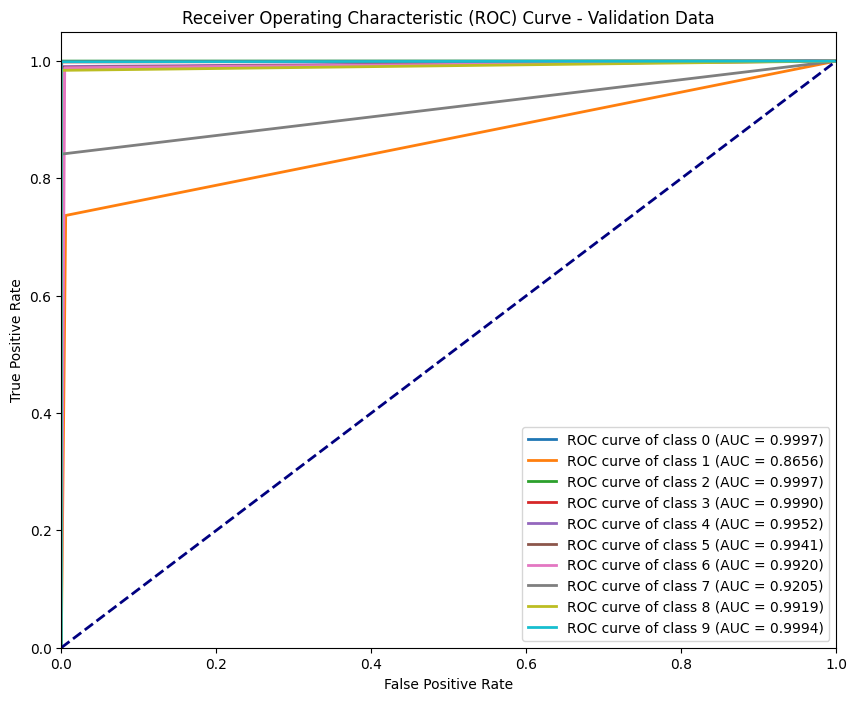

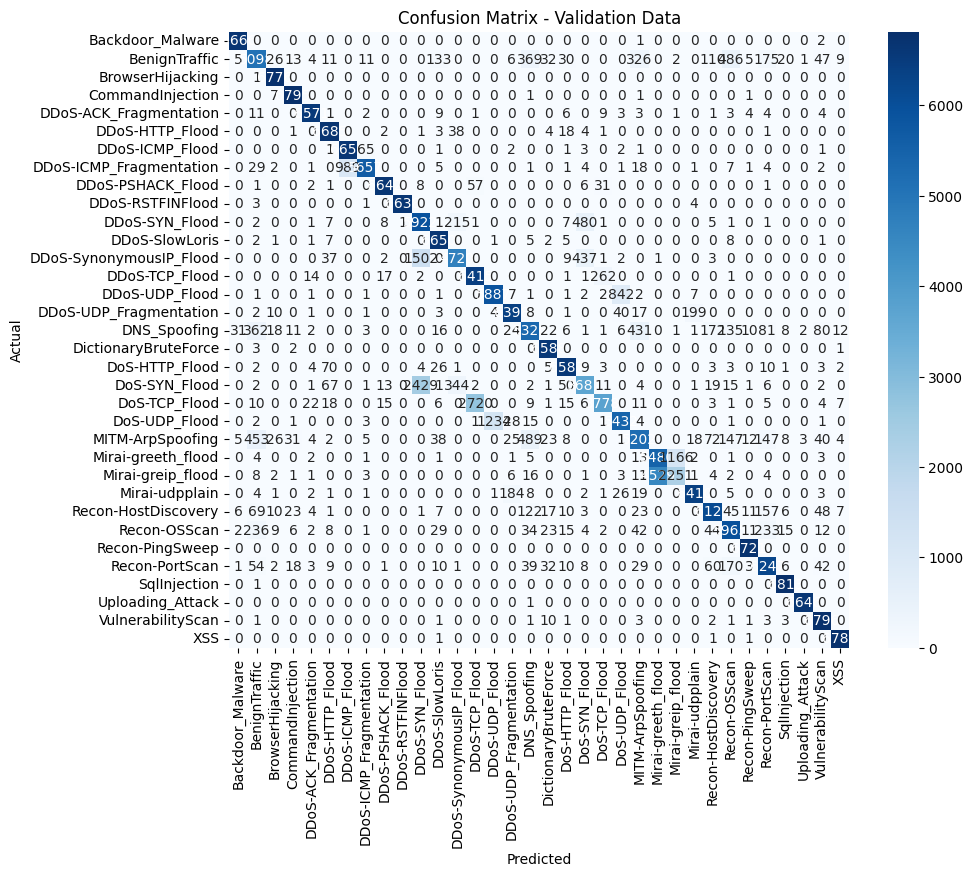

Classification Report - Validation Data:
                         precision    recall  f1-score   support

       Backdoor_Malware   0.992555  0.999550  0.996040      6669
          BenignTraffic   0.801446  0.736812  0.767771      6919
       BrowserHijacking   0.983454  0.999852  0.991586      6777
       CommandInjection   0.984497  0.998530  0.991464      6805
 DDoS-ACK_Fragmentation   0.989162  0.990653  0.989907      6633
        DDoS-HTTP_Flood   0.965204  0.989198  0.977053      6758
        DDoS-ICMP_Flood   0.870533  0.988554  0.925797      6727
DDoS-ICMP_Fragmentation   0.982801  0.841440  0.906643      6723
      DDoS-PSHACK_Flood   0.991343  0.984146  0.987731      6749
       DDoS-RSTFINFlood   0.999849  0.998796  0.999323      6646
         DDoS-SYN_Flood   0.600061  0.890125  0.716862      6653
         DDoS-SlowLoris   0.957937  0.995062  0.976147      6683
DDoS-SynonymousIP_Flood   0.887385  0.703009  0.784509      6714
         DDoS-TCP_Flood   0.697510  0.955609  0.

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt


model.eval()
total_eval_loss = 0
predictions, true_labels = [], []

for batch in val_dataloader:
    b_input_ids = batch[0].cuda()
    b_input_mask = batch[1].cuda()
    b_labels = batch[2].cuda()

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

    total_eval_loss += loss.item()

    preds = logits.argmax(dim=1)
    predictions.extend(preds.tolist())
    true_labels.extend(b_labels.tolist())

avg_val_loss = total_eval_loss / len(val_dataloader)

# Convert logits to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compute ROC curve and ROC area for each class
n_classes = number_of_categories
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10').colors
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Data')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot the confusion matrix for validation data
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Print classification report
print("Classification Report - Validation Data:")
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_, digits=6))


In [ ]:
# Calculate other metrics
val_precision = precision_score(true_labels, predictions, average='weighted')
val_recall = recall_score(true_labels, predictions, average='weighted')
val_f1 = f1_score(true_labels, predictions, average='weighted')

# Calculate accuracy
avg_val_accuracy = accuracy_score(true_labels, predictions)

# Print metrics
print(f'Validation Loss: {avg_val_loss}')
print(f'Validation Accuracy: {avg_val_accuracy}')
print(f'Validation Precision: {val_precision}')
print(f'Validation Recall: {val_recall}')
print(f'Validation F1 Score: {val_f1}')



Validation Loss: 0.268752480579659
Validation Accuracy: 0.8880926757137483
Validation Precision: 0.894959935864804
Validation Recall: 0.8880926757137483
Validation F1 Score: 0.8850704572562537


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
<ipython-input-44-456170d3f617>:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10').colors


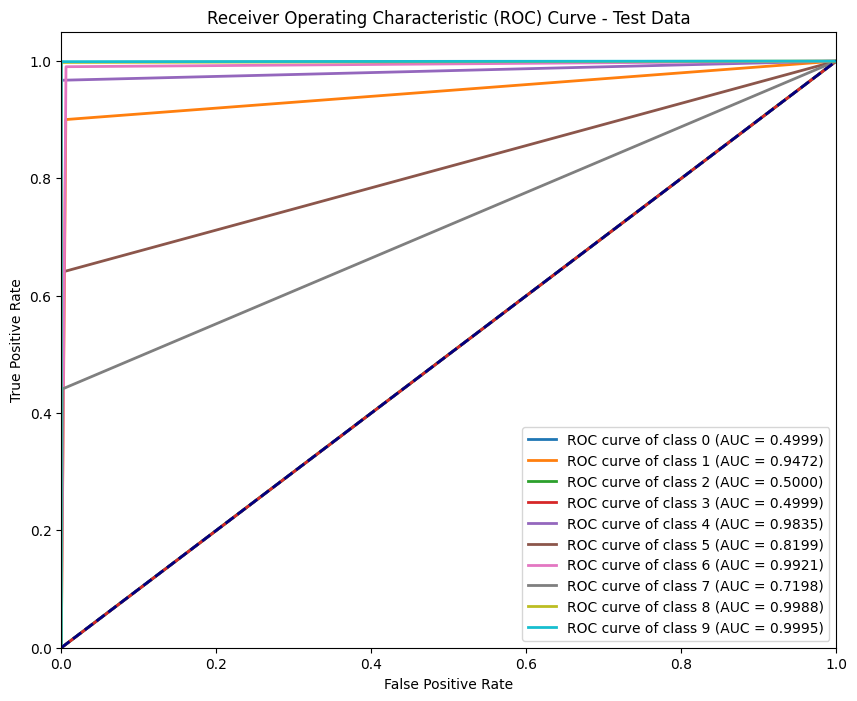

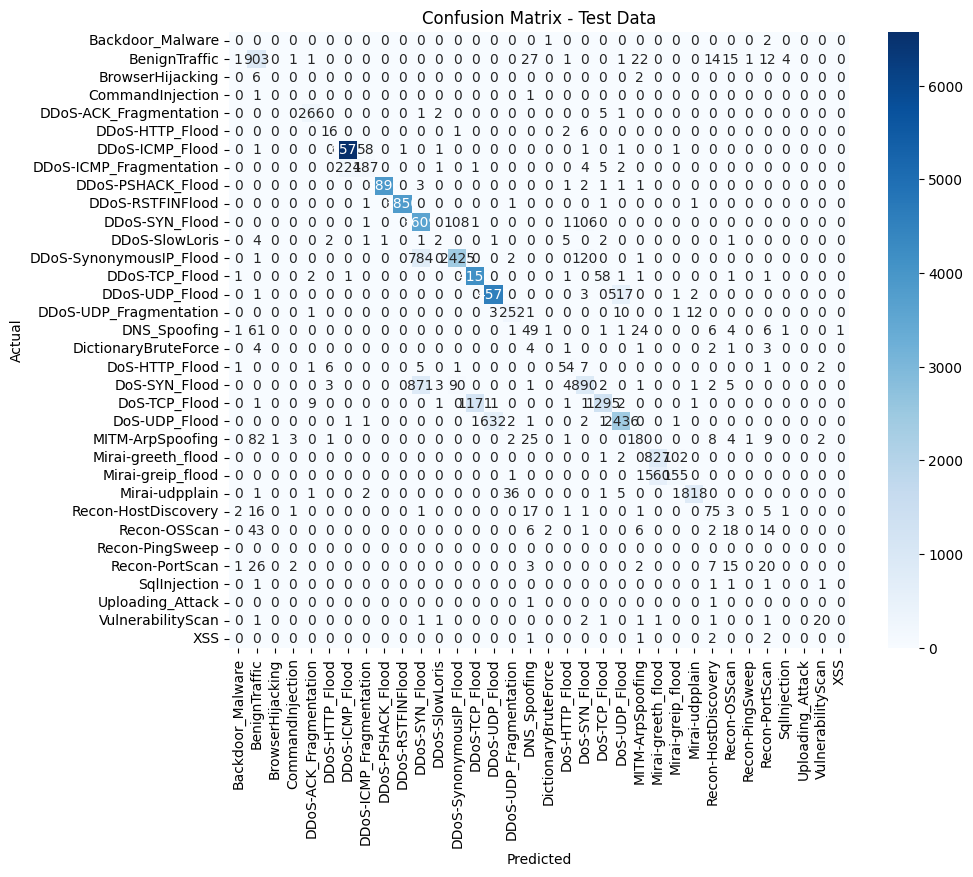

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import time  # Import the time module

# Evaluation on test set
model.eval()
total_eval_loss = 0
predictions, true_labels = [], []

# Start timing
start_time = time.time()

for batch in test_dataloader:
    b_input_ids = batch[0].cuda()
    b_input_mask = batch[1].cuda()
    b_labels = batch[2].cuda()

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

    total_eval_loss += loss.item()

    preds = logits.argmax(dim=1)
    predictions.extend(preds.tolist())
    true_labels.extend(b_labels.tolist())

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

avg_test_loss = total_eval_loss / len(test_dataloader)

# Convert logits to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compute ROC curve and ROC area for each class
n_classes = number_of_categories
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10').colors
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot the confusion matrix for test data
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Test Data')
plt.show()




In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report - Test Data:")

# Get the unique classes in the test set predictions
unique_classes_test = np.unique(true_labels)

# Ensure that all classes present in the test set are included in target_names_test
# Filter the label encoder classes to include only those present in the test set
target_names_test = [label_encoder.classes_[i] for i in unique_classes_test]

# Ensure the number of labels matches the number of target names
labels_test = list(unique_classes_test)  # Unique class labels
target_names_test = [label_encoder.classes_[i] for i in labels_test]  # Target names corresponding to these labels

# Print classification report
print(classification_report(true_labels, predictions, target_names=target_names_test, labels=labels_test, digits=6))


Classification Report - Test Data:
                         precision    recall  f1-score   support

       Backdoor_Malware   0.000000  0.000000  0.000000         3
          BenignTraffic   0.783174  0.900299  0.837662      1003
       BrowserHijacking   0.000000  0.000000  0.000000         8
       CommandInjection   0.000000  0.000000  0.000000         2
 DDoS-ACK_Fragmentation   0.946619  0.967273  0.956835       275
        DDoS-HTTP_Flood   0.571429  0.640000  0.603774        25
        DDoS-ICMP_Flood   0.966760  0.990357  0.978416      6637
DDoS-ICMP_Fragmentation   0.745020  0.441038  0.554074       424
      DDoS-PSHACK_Flood   0.999743  0.997695  0.998718      3905
       DDoS-RSTFINFlood   0.999740  0.998962  0.999351      3854
         DDoS-SYN_Flood   0.684041  0.943283  0.793013      3826
         DDoS-SlowLoris   0.181818  0.100000  0.129032        20
DDoS-SynonymousIP_Flood   0.923810  0.727573  0.814032      3333
         DDoS-TCP_Flood   0.779489  0.984112  0.869930

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

# Print accuracy, loss, precision, recall, F1-score, and time
print(f'Accuracy: {accuracy:.6f}')
print(f'Average Test Loss: {avg_test_loss:.6f}')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')
print(f'F1-Score: {f1:.6f}')
print(f'Time taken for detection: {elapsed_time:.2f} seconds')

Accuracy: 0.857796
Average Test Loss: 0.387458
Precision: 0.865559
Recall: 0.857796
F1-Score: 0.850172
Time taken for detection: 184.59 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#***X-IIoTID***

In [ ]:
# Load the X-IIoTID dataset from a CSV file and retrieve its shape
# Ensure the CSV file is located at the specified path
df = pd.read_csv('/content/drive/MyDrive/X-IIoTID dataset.csv', low_memory=False)

In [ ]:
df.head()

,Date,Timestamp,Scr_IP,Scr_port,Des_IP,Des_port,Protocol,Service,Duration,Scr_bytes,...,OSSEC_alert_level,Login_attempt,Succesful_login,File_activity,Process_activity,read_write_physical.process,is_privileged,class1,class2,class3
0,9/01/2020,1578540956,192.168.2.199,49278,192.168.2.10,80,tcp,http,0.67369,13437,...,5,0,0,0,0,0,0,Scanning_vulnerability,Reconnaissance,Attack
1,13/01/2020,1578871873,10.0.1.5,39769,131.236.3.92,53,udp,dns,0.000083,78,...,0,0,0,0,0,0,0,Normal,Normal,Normal
2,9/01/2020,1578522486,172.24.1.80,59050,172.24.1.1,53,udp,dns,0.000132,38,...,0,0,0,0,0,0,0,Normal,Normal,Normal
3,27/02/2020,1582757640,192.168.2.196,37966,192.168.2.10,1880,tcp,websocket,9.378481,1121,...,0,1,1,1,1,1,1,Normal,Normal,Normal
4,16/12/2019,1576452612,172.24.1.80,38233,172.24.1.1,53,udp,dns,0.000074,-,...,0,0,0,0,0,0,0,Normal,Normal,Normal


In [ ]:
# Print the shape of the DataFrame
shape = df.shape
print(shape)


(820834, 68)


In [ ]:
df.isnull().sum()

,0
Date,331
Timestamp,297
Scr_IP,0
Scr_port,0
Des_IP,0
Des_port,0
Protocol,0
Service,0
Duration,0
Scr_bytes,0


In [ ]:
import pandas as pd

# Adjust display settings to show all columns
pd.set_option('display.max_rows', None)

# Count the number of null values in each column
null_counts = df.isnull().sum()

# Print the null counts for each column
print(null_counts)

# Reset the display settings if needed
pd.reset_option('display.max_rows')


Date                           331
Timestamp                      297
Scr_IP                           0
Scr_port                         0
Des_IP                           0
Des_port                         0
Protocol                         0
Service                          0
Duration                         0
Scr_bytes                        0
Des_bytes                        0
Conn_state                       0
missed_bytes                     0
is_syn_only                      0
Is_SYN_ACK                       0
is_pure_ack                      0
is_with_payload                  0
FIN or RST                       0
Bad_checksum                     0
is_SYN_with_RST                  0
Scr_pkts                         0
Scr_ip_bytes                     0
Des_pkts                         0
Des_ip_bytes                     0
anomaly_alert                    0
total_bytes                      0
total_packet                     0
paket_rate                       0
byte_rate           

In [ ]:
df[df.duplicated()].shape

(6222, 68)

In [ ]:
# Display the duplicate rows
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)


              Date   Timestamp          Scr_IP Scr_port         Des_IP  \
5591    21/01/2020  1579585116  192.168.10.155    50192   192.168.2.10   
5630    22/01/2020  1579642499        10.0.1.5    47366   129.94.0.197   
14297   22/01/2020  1579646142    172.24.1.213    51975     172.24.1.1   
15801   10/02/2020  1580966999    172.24.1.100     5353    224.0.0.251   
17484   21/01/2020  1579571748  192.168.10.155    44790   192.168.2.10   
...            ...         ...             ...      ...            ...   
820582  21/01/2020  1579570754    192.168.2.10    56610  192.168.2.199   
820623  21/01/2020  1579572659  192.168.10.153    53437   192.168.2.10   
820641  21/01/2020  1579572094    192.168.2.10    33124  192.168.2.199   
820771  21/01/2020  1579570246    192.168.2.10    54714  192.168.2.199   
820823  21/01/2020  1579586256   192.168.2.196    45356   192.168.2.10   

       Des_port Protocol    Service  Duration Scr_bytes  ...  \
5591         80      tcp       http  2.412449  

In [ ]:
# Remove duplicate rows and keep the first occurrence
df= df.drop_duplicates()

In [ ]:
df[df.duplicated()].shape

(0, 68)

In [ ]:
df.shape

(814612, 68)

In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814612 entries, 0 to 820833
Data columns (total 68 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Date                         814281 non-null  object
 1   Timestamp                    814315 non-null  object
 2   Scr_IP                       814612 non-null  object
 3   Scr_port                     814612 non-null  object
 4   Des_IP                       814612 non-null  object
 5   Des_port                     814612 non-null  object
 6   Protocol                     814612 non-null  object
 7   Service                      814612 non-null  object
 8   Duration                     814612 non-null  object
 9   Scr_bytes                    814612 non-null  object
 10  Des_bytes                    814612 non-null  object
 11  Conn_state                   814612 non-null  int64 
 12  missed_bytes                 814612 non-null  object
 13  is_syn_only        

In [ ]:
from sklearn.preprocessing import LabelEncoder
columns_to_encode = [
    'Date', 'Timestamp', 'Scr_IP', 'Scr_port', 'Des_IP', 'Des_port',
    'Protocol', 'Service', 'Duration', 'Scr_bytes', 'Des_bytes',
    'missed_bytes', 'Scr_pkts', 'Scr_ip_bytes', 'Des_pkts',
    'Des_ip_bytes', 'anomaly_alert', 'total_bytes', 'total_packet',
    'paket_rate', 'byte_rate', 'Scr_packts_ratio', 'Des_pkts_ratio',
    'Scr_bytes_ratio', 'Des_bytes_ratio', 'Avg_user_time', 'Std_user_time',
    'Avg_nice_time', 'Std_nice_time', 'Avg_system_time', 'Std_system_time',
    'Avg_iowait_time', 'Std_iowait_time', 'Avg_ideal_time', 'Std_ideal_time',
    'Avg_tps', 'Std_tps', 'Avg_rtps', 'Std_rtps', 'Avg_wtps', 'Std_wtps',
    'Avg_ldavg_1', 'Std_ldavg_1', 'Avg_kbmemused', 'Std_kbmemused',
    'Avg_num_Proc/s', 'Std_num_proc/s', 'Avg_num_cswch/s', 'std_num_cswch/s'

]
for column in columns_to_encode:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814612 entries, 0 to 820833
Data columns (total 68 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Date                         814612 non-null  int64 
 1   Timestamp                    814612 non-null  int64 
 2   Scr_IP                       814612 non-null  int64 
 3   Scr_port                     814612 non-null  int64 
 4   Des_IP                       814612 non-null  int64 
 5   Des_port                     814612 non-null  int64 
 6   Protocol                     814612 non-null  int64 
 7   Service                      814612 non-null  int64 
 8   Duration                     814612 non-null  int64 
 9   Scr_bytes                    814612 non-null  int64 
 10  Des_bytes                    814612 non-null  int64 
 11  Conn_state                   814612 non-null  int64 
 12  missed_bytes                 814612 non-null  int64 
 13  is_syn_only        

In [ ]:
df.shape

(814612, 68)

In [ ]:

df = df.drop('class2', axis = 1)

In [ ]:
df = df.drop('class3', axis = 1)

In [ ]:

df.head()

,Date,Timestamp,Scr_IP,Scr_port,Des_IP,Des_port,Protocol,Service,Duration,Scr_bytes,...,std_num_cswch/s,OSSEC_alert,OSSEC_alert_level,Login_attempt,Succesful_login,File_activity,Process_activity,read_write_physical.process,is_privileged,class1
0,47,30649,25,37284,63,6020,2,4,88457,2112,...,4088,1,5,0,0,0,0,0,0,Scanning_vulnerability
1,5,36769,2,27007,12,4973,3,2,83,19237,...,17287,0,0,0,0,0,0,0,0,Normal
2,47,24817,16,47837,51,4973,3,2,132,12458,...,26013,0,0,0,0,0,0,0,0,Normal
3,32,182036,24,25062,63,1192,2,16,324051,779,...,46137,0,0,1,1,1,1,1,1,Normal
4,11,3824,16,25352,51,4973,3,2,74,0,...,34894,0,0,0,0,0,0,0,0,Normal


In [ ]:
X_TON_IOT = df.drop('class1', axis = 1)
y_TON_IOT= df['class1']
X_TON_IOT.shape, y_TON_IOT.shape

((814612, 65), (814612,))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
X_TON_IOT_train, X_TON_IOT_test,y_TON_IOT_train, y_TON_IOT_test = train_test_split(X_TON_IOT, y_TON_IOT, test_size=0.2, random_state = 1337
)


In [ ]:
df = pd.concat([X_TON_IOT_train, y_TON_IOT_train], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 651689 entries, 443933 to 266089
Data columns (total 66 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Date                         651689 non-null  int64 
 1   Timestamp                    651689 non-null  int64 
 2   Scr_IP                       651689 non-null  int64 
 3   Scr_port                     651689 non-null  int64 
 4   Des_IP                       651689 non-null  int64 
 5   Des_port                     651689 non-null  int64 
 6   Protocol                     651689 non-null  int64 
 7   Service                      651689 non-null  int64 
 8   Duration                     651689 non-null  int64 
 9   Scr_bytes                    651689 non-null  int64 
 10  Des_bytes                    651689 non-null  int64 
 11  Conn_state                   651689 non-null  int64 
 12  missed_bytes                 651689 non-null  int64 
 13  is_syn_only   

In [ ]:
print(df.groupby("class1").size())

class1
BruteForce                         37735
C&C                                 2326
Dictionary                          1913
Discovering_resources              18439
Exfiltration                       17727
Fake_notification                     25
False_data_injection                4019
Generic_scanning                   39976
MQTT_cloud_broker_subscription     18847
MitM                                  95
Modbus_register_reading             4853
Normal                            334799
RDOS                              113082
Reverse_shell                        807
Scanning_vulnerability             42266
TCP Relay                           1676
crypto-ransomware                    368
fuzzing                              937
insider_malcious                   11799
dtype: int64


In [ ]:
# Create filtered DataFrames for each type of class in the 'class1' column

df_0 = df[df['class1'] == 'BruteForce']
df_1 = df[df['class1'] == 'C&C']
df_2 = df[df['class1'] == 'Dictionary']
df_3 = df[df['class1'] == 'Discovering_resources']
df_4 = df[df['class1'] == 'Exfiltration']
df_5 = df[df['class1'] == 'Fake_notification']
df_6 = df[df['class1'] == 'False_data_injection']
df_7 = df[df['class1'] == 'Generic_scanning']
df_8 = df[df['class1'] == 'MQTT_cloud_broker_subscription']
df_9 = df[df['class1'] == 'MitM']
df_10 = df[df['class1'] == 'Modbus_register_reading']
df_11 = df[df['class1'] == 'Normal']
df_12 = df[df['class1'] == 'RDOS']
df_13 = df[df['class1'] == 'Reverse_shell']
df_14 = df[df['class1'] == 'Scanning_vulnerability']
df_15 = df[df['class1'] == 'TCP Relay']
df_16 = df[df['class1'] == 'crypto-ransomware']
df_17 = df[df['class1'] == 'fuzzing']
df_18 = df[df['class1'] == 'insider_malcious']

In [ ]:
# Sampling to balance the classes
sample_size = 34300  # Maximum number of samples per class
# Randomly sample from each class DataFrame, ensuring no more than sample_size samples are taken
df_0 = df_0.sample(min(len(df_0), sample_size), random_state=0)
df_1 = df_1.sample(min(len(df_1), sample_size), random_state=0)
df_2 = df_2.sample(min(len(df_2), sample_size), random_state=0)
df_3 = df_3.sample(min(len(df_3), sample_size), random_state=0)
df_4 = df_4.sample(min(len(df_4), sample_size), random_state=0)
df_5 = df_5.sample(min(len(df_5), sample_size), random_state=0)
df_6 = df_6.sample(min(len(df_6), sample_size), random_state=0)
df_7 = df_7.sample(min(len(df_7), sample_size), random_state=0)
df_8 = df_8.sample(min(len(df_8), sample_size), random_state=0)
df_9 = df_9.sample(min(len(df_9), sample_size), random_state=0)
df_10 = df_10.sample(min(len(df_10), sample_size), random_state=0)
df_11 = df_11.sample(min(len(df_11), sample_size), random_state=0)
df_12 = df_12.sample(min(len(df_12), sample_size), random_state=0)
df_13 = df_13.sample(min(len(df_13), sample_size), random_state=0)
df_14 = df_14.sample(min(len(df_14), sample_size), random_state=0)
df_15 = df_15.sample(min(len(df_15), sample_size), random_state=0)
df_16 = df_16.sample(min(len(df_16), sample_size), random_state=0)
df_17 = df_17.sample(min(len(df_17), sample_size), random_state=0)
df_18 = df_18.sample(min(len(df_18), sample_size), random_state=0)

# Concatenate the sampled DataFrames into a single balanced DataFrame
df_Edge_IIoTset_cleaned = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9,
                                     df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17, df_18], axis=0)

# Display class statistics in the balanced DataFrame
print('Balanced sampling:')
print(df_Edge_IIoTset_cleaned['class1'].value_counts())

Balanced sampling:
class1
BruteForce                        34300
Scanning_vulnerability            34300
RDOS                              34300
Normal                            34300
Generic_scanning                  34300
MQTT_cloud_broker_subscription    18847
Discovering_resources             18439
Exfiltration                      17727
insider_malcious                  11799
Modbus_register_reading            4853
False_data_injection               4019
C&C                                2326
Dictionary                         1913
TCP Relay                          1676
fuzzing                             937
Reverse_shell                       807
crypto-ransomware                   368
MitM                                 95
Fake_notification                    25
Name: count, dtype: int64


In [ ]:
X_TON_IOT = df_Edge_IIoTset_cleaned.drop('class1', axis = 1)
y_TON_IOT= df_Edge_IIoTset_cleaned['class1']
X_TON_IOT.shape, y_TON_IOT.shape

((255331, 65), (255331,))

In [ ]:
from imblearn.over_sampling import SMOTE

# Create the SMOTE oversampler
smt = SMOTE(random_state=42) #
# Apply SMOTE to balance the classes in the training dataset
X_TON_IOT_train, y_TON_IOT_train = smt.fit_resample(X_TON_IOT, y_TON_IOT)

In [ ]:
y_TON_IOT_train.value_counts()

,count
class1,
BruteForce,34300
Modbus_register_reading,34300
fuzzing,34300
crypto-ransomware,34300
TCP Relay,34300
Scanning_vulnerability,34300
Reverse_shell,34300
RDOS,34300
Normal,34300


In [ ]:
X_TON_IOT_train, X_TON_IOT_valid,y_TON_IOT_train, y_TON_IOT_valid = train_test_split(X_TON_IOT_train, y_TON_IOT_train, test_size=0.25, random_state = 1337
)

In [ ]:
y_TON_IOT_test.value_counts()

,count
class1,
Normal,83454
RDOS,28179
Scanning_vulnerability,10559
Generic_scanning,10277
BruteForce,9506
Discovering_resources,4709
MQTT_cloud_broker_subscription,4677
Exfiltration,4407
insider_malcious,2945


In [ ]:
y_TON_IOT_train.value_counts()

,count
class1,
Fake_notification,25856
Dictionary,25852
Generic_scanning,25824
Reverse_shell,25805
Normal,25799
Discovering_resources,25788
BruteForce,25785
Modbus_register_reading,25784
insider_malcious,25766


In [ ]:
y_TON_IOT_valid.value_counts()

,count
class1,
MQTT_cloud_broker_subscription,8838
crypto-ransomware,8728
False_data_injection,8713
MitM,8641
C&C,8625
Scanning_vulnerability,8601
fuzzing,8599
RDOS,8594
TCP Relay,8578


In [ ]:
train_df = pd.concat([X_TON_IOT_train, y_TON_IOT_train], axis=1)
val_df = pd.concat([X_TON_IOT_valid, y_TON_IOT_valid], axis=1)
test_df = pd.concat([ X_TON_IOT_test,y_TON_IOT_test ], axis=1)


In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import time
import datetime
import random


columns_to_concat = [col for col in train_df.columns if col not in [ 'class1']]
train_df['text'] = train_df[columns_to_concat].astype(str).agg(' '.join, axis=1)
train_df = train_df[[ 'class1', 'text']]
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

columns_to_concat = [col for col in val_df.columns if col not in [ 'class1']]
val_df['text'] = val_df[columns_to_concat].astype(str).agg(' '.join, axis=1)
val_df = val_df[['class1', 'text']]
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

columns_to_concat = [col for col in test_df.columns if col not in ['class1']]
test_df['text'] = test_df[columns_to_concat].astype(str).agg(' '.join, axis=1)
test_df = test_df[[ 'class1', 'text']]
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)





# Sauvegarder les fichiers CSV
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

# Afficher la taille de chaque partie
print(f'Train set size: {train_df.shape[0]}')
print(f'Validation set size: {val_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')


Train set size: 488775
Validation set size: 162925
Test set size: 162923


In [ ]:
label_encoder = LabelEncoder()
train_df['encoded_categories'] = label_encoder.fit_transform(train_df["class1"])
val_df['encoded_categories'] = label_encoder.transform(val_df["class1"])
test_df['encoded_categories'] = label_encoder.transform(test_df["class1"])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 80

def prepare_data(df, max_len, tokenizer):
    texts = df.text.values
    labels = df.encoded_categories.values

    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return TensorDataset(input_ids, attention_masks, labels)

train_dataset = prepare_data(train_df, max_len, tokenizer)
val_dataset = prepare_data(val_df, max_len, tokenizer)
test_dataset = prepare_data(test_df, max_len, tokenizer)

batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import pickle
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Save the training dataset to a pickle file
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)
# Save the validation dataset to a pickle file
with open('val_dataset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)
# Save the test dataset to a pickle file
with open('test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)



In [ ]:
# Load the datasets from pickle files
with open('/content/drive/MyDrive/train_dataset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

with open('/content/drive/MyDrive/val_dataset.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

with open('/content/drive/MyDrive/test_dataset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

with open('/content/drive/MyDrive/train_dataset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

with open('/content/drive/MyDrive/val_dataset.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

with open('/content/drive/MyDrive/test_dataset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)


In [ ]:
number_of_categories = len(train_df['encoded_categories'].unique())

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=number_of_categories,
    output_attentions=False,
    output_hidden_states=False,
)

model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:

epochs = 1
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


seed_val = 1903
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score
import time
import numpy as np
import torch

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))


total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()


        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        total_train_accuracy += accuracy_score(b_labels.cpu().numpy(), preds)

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.6f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))
    print("Training Accuracy: {0:.6f}".format(avg_train_accuracy))

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Training Accur.': avg_train_accuracy,
        'Training Time': training_time
    })

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


======== Epoch 1 / 1 ========
Batch    10  of  15,275.    Elapsed: 0:00:06.
Batch    20  of  15,275.    Elapsed: 0:00:10.
Batch    30  of  15,275.    Elapsed: 0:00:14.
Batch    40  of  15,275.    Elapsed: 0:00:18.
Batch    50  of  15,275.    Elapsed: 0:00:22.
Batch    60  of  15,275.    Elapsed: 0:00:26.
Batch    70  of  15,275.    Elapsed: 0:00:30.
Batch    80  of  15,275.    Elapsed: 0:00:34.
Batch    90  of  15,275.    Elapsed: 0:00:38.
Batch   100  of  15,275.    Elapsed: 0:00:42.
Batch   110  of  15,275.    Elapsed: 0:00:46.
Batch   120  of  15,275.    Elapsed: 0:00:50.
Batch   130  of  15,275.    Elapsed: 0:00:54.
Batch   140  of  15,275.    Elapsed: 0:00:59.
Batch   150  of  15,275.    Elapsed: 0:01:03.
Batch   160  of  15,275.    Elapsed: 0:01:07.
Batch   170  of  15,275.    Elapsed: 0:01:11.
Batch   180  of  15,275.    Elapsed: 0:01:15.
Batch   190  of  15,275.    Elapsed: 0:01:20.
Batch   200  of  15,275.    Elapsed: 0:01:24.
Batch   210  of  15,275.    Elapsed: 0:01:28.
Batc

<ipython-input-49-63f2d1a64e65>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10').colors


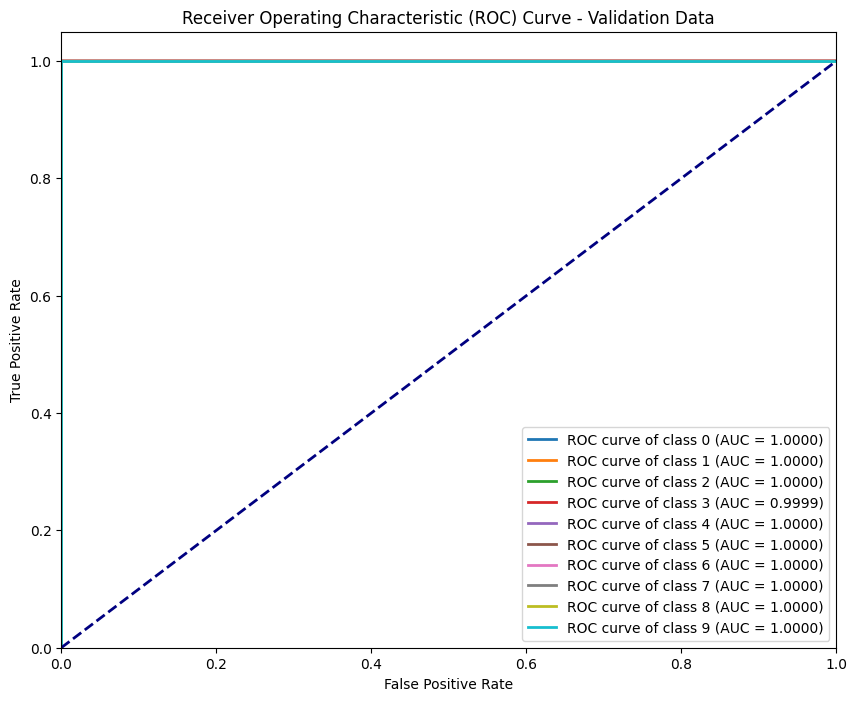

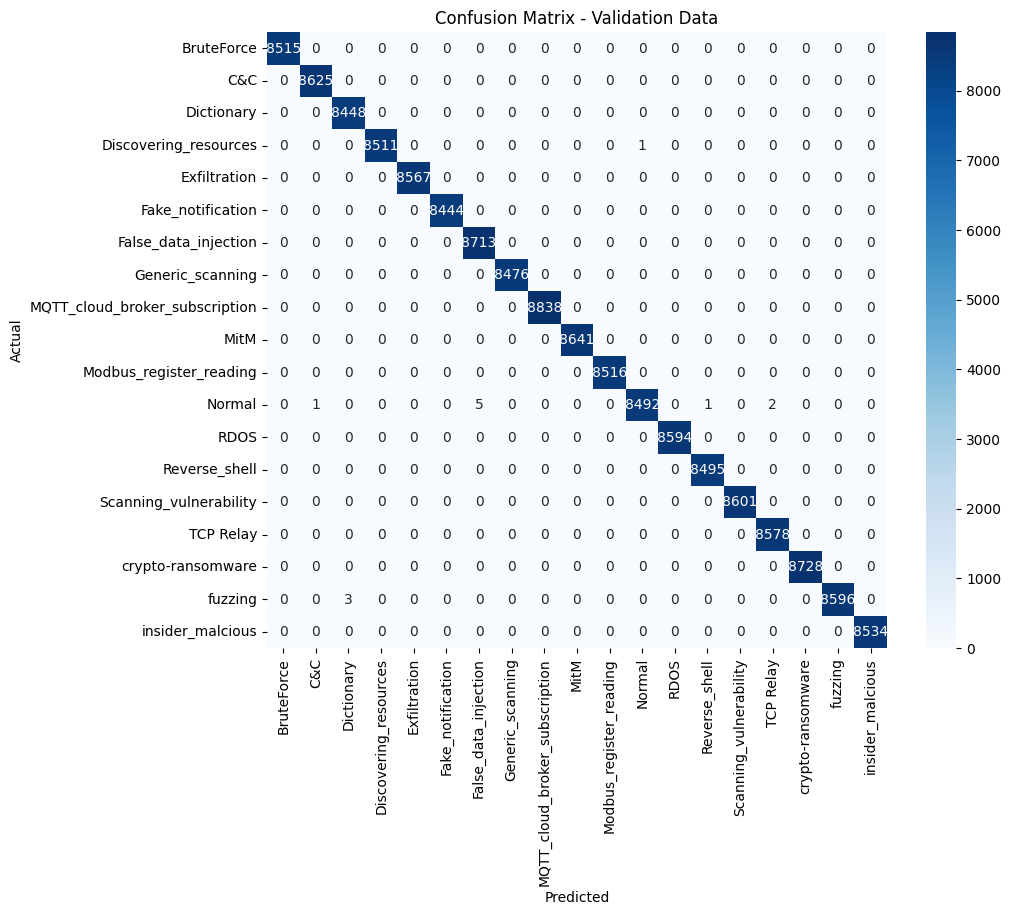

Classification Report - Validation Data:
                                precision    recall  f1-score   support

                    BruteForce   1.000000  1.000000  1.000000      8515
                           C&C   0.999884  1.000000  0.999942      8625
                    Dictionary   0.999645  1.000000  0.999822      8448
         Discovering_resources   1.000000  0.999883  0.999941      8512
                  Exfiltration   1.000000  1.000000  1.000000      8567
             Fake_notification   1.000000  1.000000  1.000000      8444
          False_data_injection   0.999426  1.000000  0.999713      8713
              Generic_scanning   1.000000  1.000000  1.000000      8476
MQTT_cloud_broker_subscription   1.000000  1.000000  1.000000      8838
                          MitM   1.000000  1.000000  1.000000      8641
       Modbus_register_reading   1.000000  1.000000  1.000000      8516
                        Normal   0.999882  0.998941  0.999412      8501
                      

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Evaluation on validation set
model.eval()
total_eval_loss = 0
predictions, true_labels = [], []

for batch in val_dataloader:
    b_input_ids = batch[0].cuda()
    b_input_mask = batch[1].cuda()
    b_labels = batch[2].cuda()

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

    total_eval_loss += loss.item()

    preds = logits.argmax(dim=1)
    predictions.extend(preds.tolist())
    true_labels.extend(b_labels.tolist())

avg_val_loss = total_eval_loss / len(val_dataloader)

# Convert logits to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compute ROC curve and ROC area for each class
n_classes = number_of_categories
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10').colors
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Data')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot the confusion matrix for validation data
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Print classification report
print("Classification Report - Validation Data:")
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_, digits=6))


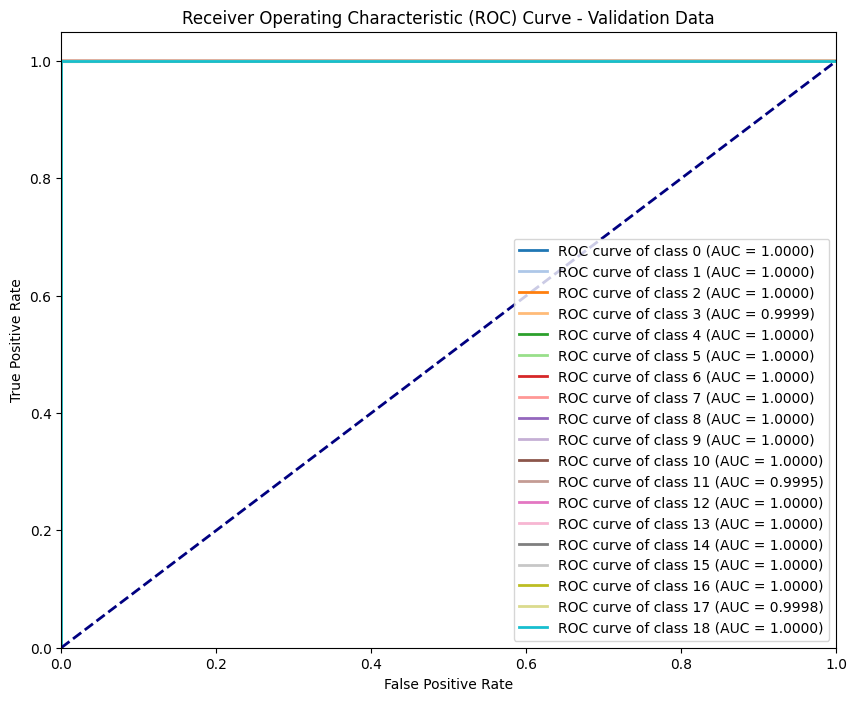

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
n_classes = number_of_categories  # Replace with the actual number of categories
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.colormaps.get_cmap('tab20').colors
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Data')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Calculate other metrics
val_precision = precision_score(true_labels, predictions, average='weighted')
val_recall = recall_score(true_labels, predictions, average='weighted')
val_f1 = f1_score(true_labels, predictions, average='weighted')
val_accuracy = accuracy_score(true_labels, predictions)

print(f'Validation Loss: {avg_val_loss}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation Precision: {val_precision}')
print(f'Validation Recall: {val_recall}')
print(f'Validation F1 Score: {val_f1}')


Validation Loss: 0.0005514767402652956
Validation Accuracy: 0.9999202086849778
Validation Precision: 0.999920231336334
Validation Recall: 0.9999202086849778
Validation F1 Score: 0.9999201995613202


<ipython-input-54-d0d56fdf0f6d>:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10').colors


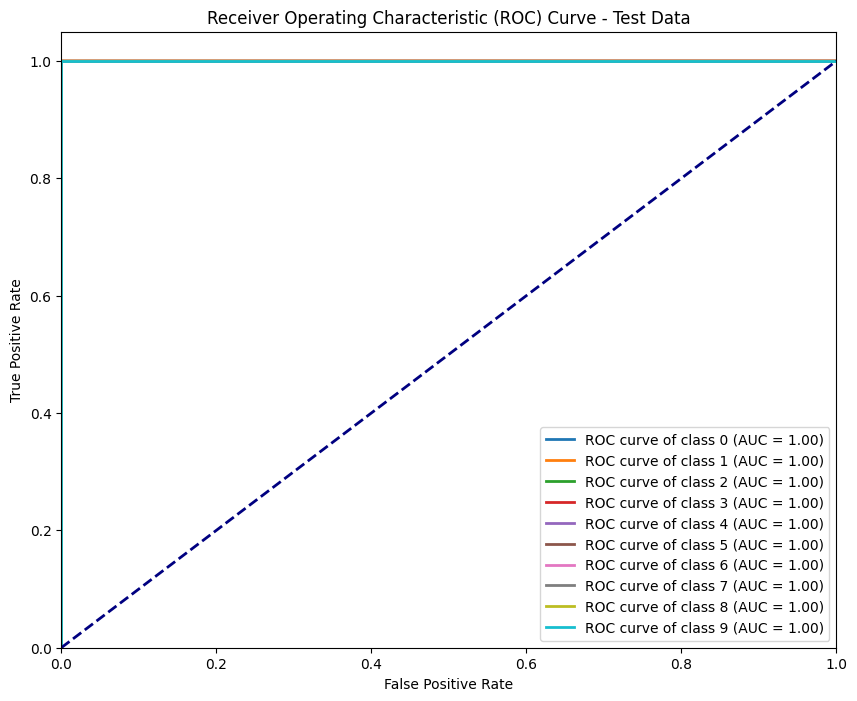

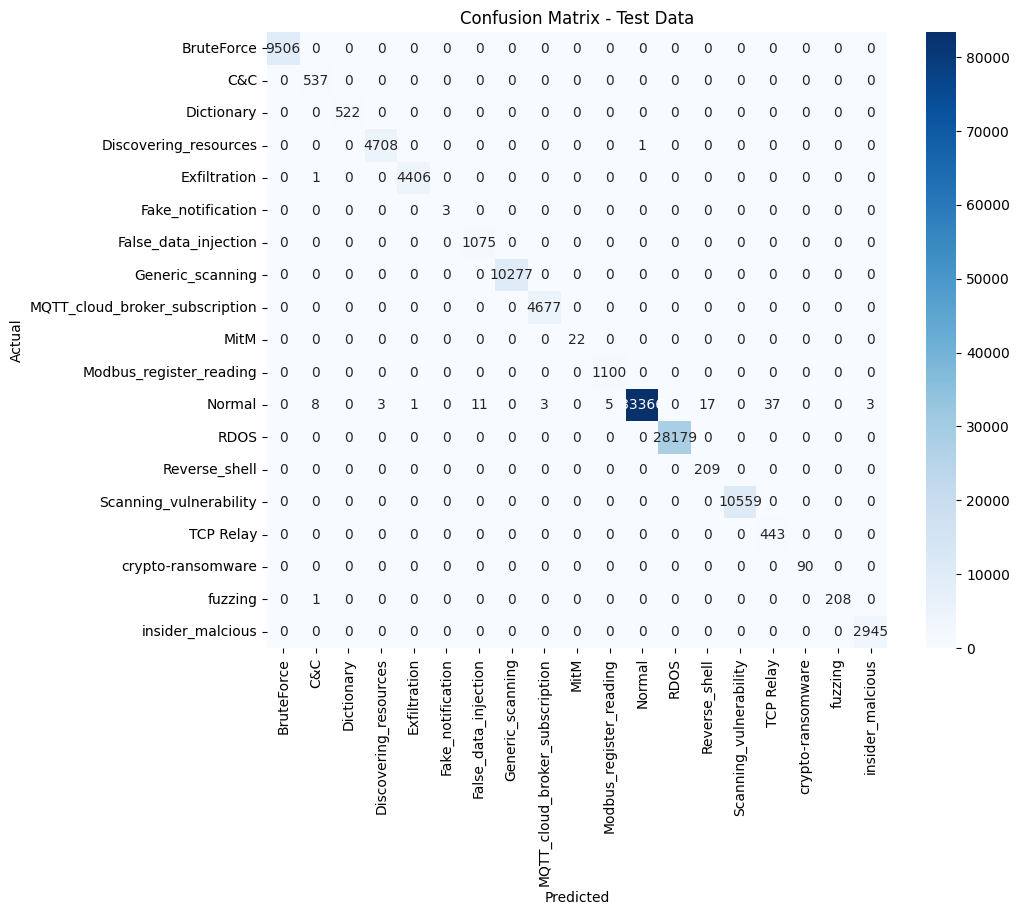

Classification Report - Test Data:
                                precision    recall  f1-score   support

                    BruteForce   1.000000  1.000000  1.000000      9506
                           C&C   0.981718  1.000000  0.990775       537
                    Dictionary   1.000000  1.000000  1.000000       522
         Discovering_resources   0.999363  0.999788  0.999575      4709
                  Exfiltration   0.999773  0.999773  0.999773      4407
             Fake_notification   1.000000  1.000000  1.000000         3
          False_data_injection   0.989871  1.000000  0.994910      1075
              Generic_scanning   1.000000  1.000000  1.000000     10277
MQTT_cloud_broker_subscription   0.999359  1.000000  0.999679      4677
                          MitM   1.000000  1.000000  1.000000        22
       Modbus_register_reading   0.995475  1.000000  0.997732      1100
                        Normal   0.999988  0.998946  0.999466     83454
                          RD

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import time  # Importer le module time

# Evaluation on test set
model.eval()
total_eval_loss = 0
predictions, true_labels = [], []


start_time = time.time()

for batch in test_dataloader:
    b_input_ids = batch[0].cuda()
    b_input_mask = batch[1].cuda()
    b_labels = batch[2].cuda()

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

    total_eval_loss += loss.item()

    preds = logits.argmax(dim=1)
    predictions.extend(preds.tolist())
    true_labels.extend(b_labels.tolist())


end_time = time.time()

# Calculer le temps de prédiction
prediction_time = end_time - start_time

avg_test_loss = total_eval_loss / len(test_dataloader)

# Convert logits to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compute ROC curve and ROC area for each class
n_classes = number_of_categories
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10').colors
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot the confusion matrix for test data
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Test Data')
plt.show()

# Print classification report
print("Classification Report - Test Data:")
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_, digits=6))

# Print prediction time
print(f"Time taken for prediction on the test set: {prediction_time:.2f} seconds")


In [ ]:
# test
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate precision, recall and F1-score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
# Print accuracy, loss, precision and recall
print(f'Accuracy: {accuracy:.6f}')
print(f'Average Test Loss: {avg_test_loss:.6f}')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')
print(f'F1-Score: {f1:.6f}')

Accuracy: 0.999441
Average Test Loss: 0.003262
Precision: 0.999469
Recall: 0.999441
F1-Score: 0.999448
